ImagingReso for plotting ideal neutron resonance

In [3]:
import _plot_functions
import _functions
import numpy as np
import pandas as pd

* Input sample info:
  1. Database selection. Only ENDF_VIII is surpported currently. 
  2. Elements you want plot as in string. Input takes chemical symbol in the form of
     'Co' as single element,  
     'AgCo' as Ag and Co foils stacked,
     UO3' as chemical compound. Chemical compound is only supported when compound_boo is 'Y', and input mixture density 
  3. Sample thickness in mm.
  4. Energy range (min, max) you would like it be plotted. Plotting in lamda is also supported.

In [4]:
'''Describe your sample: '''
# Input sample name or names as str, case sensitive
_input_formula = 'AgCo'  # input('Please input the chemicals? ')
_input_thick_mm = 0.025  # float(input('Please input the thickness or majority thickness of stacked foils in mm : '))
_input_thick_cm = _input_thick_mm/10
_database = 'ENDF_VIII'
energy_max = 300  # max incident energy in eV
energy_min = 0  # min incident energy in eV
energy_sub = 100  # steps used to interpolate database
sub_x = energy_sub * (energy_max - energy_min)  # steps used to interpolate database
compound_boo = 'N'  # Compound or single/multi elements foil/stacked foils: Y/N?

* How you would like the plot to be presented?

In [5]:
'''How you want the data to be plotted?'''
_plot_or_not = 'Y'
_energy_x_axis = 'Y'  # 1 means plot x-axis as energy in eV
_trans_y_axis = 'N'  # 1 means plot y-axis as transmission
_plot_each_ele_contribution = 'Y'  # 1 means plot each element's contribution
_plot_each_iso_contribution = 'N'  # 1 means plot each isotope's contribution
_plot_mixed = 'Y'  # 1 means plot mixed resonance

'''Export to clipboard for Excel or DataGraph?'''
_export_to_clipboard_boo = 'N'

* Parse input formula str

In [6]:
''' Parse input formula str and return:
(1) elements list, elemental ratio list
(2) isotopes dict in the form of {element1: [iso11, iso12, iso13, ...], 
                                  element2: [iso21, iso22, iso23, ...], 
                                  element3: [iso31, iso32, iso33, ...], 
                                  ...}
(3) isotopic ratio dict in the form of {element1: {iso11: iso_ratio11, iso12: iso_ratio12, iso13: iso_ratio13, ...},
                                        element2: {iso21: iso_ratio21, iso22: iso_ratio12, iso23: iso_ratio23, ...},
                                        element3: {iso31: iso_ratio31, iso32: iso_ratio12, iso33: iso_ratio33, ...},
                                        ...}
'''
formula_dict = _functions.input2formula(_input_formula)
elements = _functions.dict_key_list(formula_dict)
ratios = _functions.dict_value_list(formula_dict)
sum_ratios = sum(ratios)
isotope_dict = _functions.get_isotope_dicts(_database, elements)

Parsed chemical formula: {'Ag': 1, 'Co': 1}


* Generate dictionaries contain modified or unmodified thickness, mass of isotopes, mass of elements, atomic ratio of isotopes for each element, density.

In [7]:
# DICT 1: Thickness dict with option for modification
thick_cm_dict = _functions.repeat_value_dict(elements, _input_thick_cm)

# DICT 2: Isotopic mass dict
iso_mass_dicts = _functions.get_iso_mass_dicts_quick(elements, isotope_dict)

# Dict 3: Molar mass dict
molar_mass_dict = _functions.get_molar_mass_dict(elements)

# DICT 4: Isotope at.% dict with option for modification
iso_ratio_dicts = _functions.get_iso_ratio_dicts_quick(elements, isotope_dict)

# DICT 5: Density dict
density_gcm3_dict = _functions.get_density_dict(elements)

* The following part is only needed if there are parameters changed with input such as individual thickness or density for stacked foils. Atomic ratios of isotopes can also be modified in this step if they are differ from natural abundance.

In [8]:
# Update DICT 1: isotopic ratio changes lead to |Density| & |Molar mass| changes
# Thickness input:
special_thick_boo = 'N'
special_thick_element_str = str
special_thick_mm_list = []
special_thick_cm_list = np.array(special_thick_mm_list)/10
if compound_boo == 'N':
    if special_thick_boo == 'Y':
        thick_cm_dict = _plot_functions.modify_thick_cm_dict_by_input(thick_cm_dict, special_thick_element_str, special_thick_cm_list)

        
# Update DICT 3 & 4 & 5: isotopic ratio changes lead to |Density| & |Molar mass| changes
# Enriched isotope ratio input:
enrichment_boo = 'N'  # Isotopic enriched or depleted: Y/N?
enriched_element_str = 'U'
input_ratio_dict = {'U': [0., 0., .15, .85]}
                    # 'O': [1., 0., 0.]}  #{'233-U': 0., '234-U': 0., '235-U': 0.15, '238-U': 0.85}}
if enrichment_boo == 'Y':
    # Update isotope at.% ratio dict
    iso_ratio_dicts, enriched_element = _plot_functions.modify_iso_ratio_dicts(elements, isotope_dict, enriched_element_str, input_ratio_dict)
    # Update molar mass dict
    molar_mass_dict = _plot_functions.modify_molar_mass_dict_by_enrichment(molar_mass_dict, enriched_element, isotope_dict, iso_ratio_dicts, iso_mass_dicts)
    # Update density dict
    density_gcm3_dict = _plot_functions.modify_density_dict_by_enrichment(density_gcm3_dict, enriched_element, isotope_dict, iso_ratio_dicts)

    
# Update DICT 5: Density dict, if special case encountered
# Special density input:
special_density_boo = 'N'
special_density_element_str = str
special_density_gcm3_list = []
if compound_boo == 'N':
    if special_density_boo == 'Y':
        # Stacked foils and would like to modify density for specific element
        density_gcm3_dict = _plot_functions.modify_density_dict_by_input(density_gcm3_dict, special_density_element_str, special_density_gcm3_list)
else:
    if special_density_boo == 'Y':
        # Not isolated elements or mixture or compound need density input currently
        input_tot_density = 0.7875


*Updated DICT 6 for stoichimetric ratios

In [9]:
# Updated DICT 6 for stoichimetric ratios
# DICT 6: Stoichiometric ratio
if compound_boo == 'Y':
    # If input is compound, input formula follows the stoichimetric ratios
    ele_at_ratio_dict = {}
    for el in elements:
        ele_at_ratio_dict[el] = formula_dict[el]/sum_ratios
else:
    # If input is NOT compound, so the input are stack of elements,
    # stoichimetric ratios need to be calculated based on density and thickness
    ele_at_ratio_dict = _functions.ele_ratio_dict(elements, thick_cm_dict, density_gcm3_dict, molar_mass_dict)

* Check parameter dictionaries with print()

In [11]:
print('Thickness (cm): ', thick_cm_dict)
print('Density (g/cm^3): ', density_gcm3_dict)
print('Molar weight (g/mol): ', molar_mass_dict)
print('Stoichimetric ratio (at.%): ', ele_at_ratio_dict)
print('Isotopic ratio (at.%): ', iso_ratio_dicts)

Thickness (cm):  {'Ag': 0.0025, 'Co': 0.0025}
Density (g/cm^3):  {'Ag': 10.5, 'Co': 8.9}
Molar weight (g/mol):  {'Ag': 107.8682, 'Co': 58.9332}
Stoichimetric ratio (at.%):  {'Ag': 0.39193601106969644, 'Co': 0.6080639889303036}
Isotopic ratio (at.%):  {'Ag': {'107-Ag': 0.51839, '109-Ag': 0.48161000000000004}, 'Co': {'58-Co': 0.0, '59-Co': 1.0}}


* Extract database and calulate neutron transmission or attenuation
Equations: 
1. N(atoms_per_cm3) 
        = density / {sum[ele.at% * sum(mass * iso.at%)} 
           = density / mass_sum
2. Transmission(ideal) 
        = exp{-l * N * {sum[ele.at% * sum(sigma * iso.at%)}} 
           = exp{-l * N * sigma_sum)


* The following are steps:
1. Get N: atoms_per_cm3
2. Get sigma_sum by interpolating the resonance database into new x_axis: x_energy for each isotope
3. Get tot transmission: y_trans_tot

In [12]:
'''For plotting the database'''
sigma_iso_ele_eleisodict = {}  # For transmission calculation at isotope level
sigma_iso_ele_sum_eledict = {}  # For transmission calculation at element level
df_raw_dict = {}  # Raw sigma data for elements and isotopes

for el in elements:
    iso_ratio_list = list(dict.values(iso_ratio_dicts[el]))
    
    # Get sigma related terms
    file_names = _functions.get_file_path(_database, el)
    x_energy, sigma_iso_ele_isodict, sigma_iso_ele_sum, df_raw_dict[el] \
        = _plot_functions.get_xy_from_database(iso_ratio_dicts[el],
                                               file_names,
                                               energy_min,
                                               energy_max,
                                               iso_ratio_list,
                                               sub_x,
                                               ele_at_ratio_dict[el])
    
    # Two level dict of isotopic array of (sigma * iso_ratio * ele_ratio)
    sigma_iso_ele_eleisodict[el] = sigma_iso_ele_isodict
    # One level dict of elemental array of (sigma * iso_ratio * ele_ratio)
    sigma_iso_ele_sum_eledict[el] = sigma_iso_ele_sum

# Get term of (thickness * number of atoms per cm^3)
if compound_boo == 'Y':
    # For compound
    thick_cm_list = list(dict.values(thick_cm_dict))
    thick_cm = thick_cm_list[0]
    compound_density = input_tot_density
    mixed_l_n_avo = _plot_functions.l_x_n_compound(elements,
                                                   thick_cm,
                                                   compound_density,
                                                   molar_mass_dict,
                                                   ele_at_ratio_dict)
else:
    # Stacked foils or single foil
    mixed_l_n_avo = _plot_functions.l_x_n_multi_ele_stack(elements,
                                                          thick_cm_dict,
                                                          density_gcm3_dict,
                                                          molar_mass_dict)

# Get the tot transmission for all
yi_values = list(dict.values(sigma_iso_ele_sum_eledict))
yi_values_sum = sum(yi_values)

trans_sum = _functions.sig_l_2trans_quick(mixed_l_n_avo, yi_values_sum)
y_trans_tot = trans_sum

Thickness(l) x atoms_per_cm^3(N) :  3.739139640223701e+20


* Create dictionary contains transmission or attenuation at elemental level and isotopic level in case of plotting elemental or isotopic contributions in total resonance.

In [13]:
# Create the trans or absorb dict of ele for plotting if needed
y_ele_dict = {}
if _plot_each_ele_contribution == 'Y':
    for _ele in elements:
        if _trans_y_axis == 'Y':
            y_ele_dict[_ele] = _functions.sig_l_2trans_quick(mixed_l_n_avo, sigma_iso_ele_sum_eledict[_ele])
        else:
            y_ele_dict[_ele] = 1 - _functions.sig_l_2trans_quick(mixed_l_n_avo, sigma_iso_ele_sum_eledict[_ele])

# Create the trans or absorb dict : y_iso_dicts of isotopes for plotting if needed
y_iso_dicts = {}
if _plot_each_iso_contribution == 'Y':
    for _ele in elements:
        y_iso_dict = {}
        for _iso in isotope_dict[_ele]:
            if _trans_y_axis == 'Y':
                y_iso_dict[_iso] = _functions.sig_l_2trans_quick(mixed_l_n_avo,
                                                                 sigma_iso_ele_eleisodict[_ele][_iso])
            else:
                y_iso_dict[_iso] = 1 - _functions.sig_l_2trans_quick(mixed_l_n_avo,
                                                                     sigma_iso_ele_eleisodict[_ele][_iso])
        y_iso_dicts[_ele] = y_iso_dict

* Plot the ideal resonance data:
  x_energy, y_trans_tot
* Or plot the trans dictionaries for elemental or isotopic transmissions 

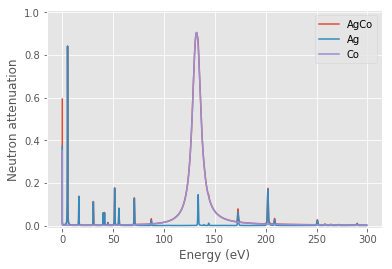

In [14]:
# Plot the theoretical neutron resonance
if _plot_or_not == 'Y':
    _plot_functions.plot_database(_energy_x_axis,
                                  _trans_y_axis,
                                  _plot_mixed,
                                  _plot_each_ele_contribution,
                                  _plot_each_iso_contribution,
                                  elements,
                                  isotope_dict,
                                  x_energy,
                                  y_trans_tot,
                                  y_ele_dict,
                                  y_iso_dicts,
                                  _input_formula)

* Option for exporting to clipboard for copy-paste into Excel or others to play with thickness and density values

Parsed chemical formula: {'Ag': 1, 'Au': 1, 'W': 1, 'Hf': 1, 'Cd': 1, 'Co': 1, 'In': 1}
Thickness (cm):  {'Ag': 0.01, 'Au': 0.01, 'W': 0.01, 'Hf': 0.01, 'Cd': 0.01, 'Co': 0.01, 'In': 0.01}


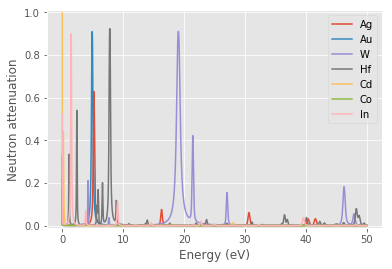

In [4]:
# Export to clipboard for density and thickness manipulations with Excel or DataGraph
if _export_to_clipboard_boo == 'Y':
    _name = _input_formula
    df_yi_tot = pd.DataFrame(data=x_energy, index=None)
    df_yi_tot.rename(columns={0: 'eV' + _name}, inplace=True)
    df_yi_tot['lamda-' + _name] = _functions.ev2lamda(x_energy)
    df_yi_tot['sample_density-' + _name] = sample_density
    df_yi_tot['avo_divided-' + _name] = avo_divi_mass_iso_ele_sum
    df_yi_tot['sigma-' + _name] = yi_values_sum

    for ele in elements:
        _ele_str = str(ele)
        df_yi_tot['sigma-' + _ele_str] = sigma_iso_ele_sum_eledict[ele]
        df_test = pd.DataFrame(sigma_iso_ele_eleisodict[ele])
        df_yi_tot = pd.concat([df_yi_tot, df_test], axis=1)
    print(df_yi_tot.head())
    # Export to clipboard
    df_yi_tot.to_clipboard(excel=True)